In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [114]:
!pip install np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, LSTM, concatenate, AveragePooling2D
from tensorflow.keras.layers import Subtract, Conv2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D, Embedding
from tensorflow.keras import regularizers
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt

import numpy as np

In [0]:
#parameters

epsilon_l2 = 0.4  #the quantity of perturbation we add to the images norm L2
epsilon_inf = 0.031 #norm infini

step_pgd = 20   #the number of steps taken during the PGD algo
eta_l2 = 0.4     #used in PGD algo
eta_inf = 0.031

(Valeurs communément acceptées) Si input est dans [0, 1], alors epsilon doit être à 

0.031 max pour la norme infinie

0.4 max pour la norme 2 (pour que ce soit invisible)

Il n'y a pas de consciensus pour l'utilisation de la norme infinie ou 2 

# Data

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [118]:
print(x_test.shape)

(10000, 32, 32, 3)


# Network

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)


adversarial = keras.models.Model(inputs=input, outputs=x)
adversarial.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [120]:
history = adversarial.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 17s 422us/sample - loss: 1.7512 - accuracy: 0.3708 - val_loss: 1.5044 - val_accuracy: 0.4635
Epoch 2/20
40000/40000 [==============================] - 25s 614us/sample - loss: 1.4202 - accuracy: 0.4960 - val_loss: 1.3701 - val_accuracy: 0.5188
Epoch 3/20
40000/40000 [==============================] - 25s 621us/sample - loss: 1.3113 - accuracy: 0.5375 - val_loss: 1.3079 - val_accuracy: 0.5530
Epoch 4/20
40000/40000 [==============================] - 26s 645us/sample - loss: 1.2438 - accuracy: 0.5667 - val_loss: 1.2583 - val_accuracy: 0.5669
Epoch 5/20
40000/40000 [==============================] - 28s 691us/sample - loss: 1.1974 - accuracy: 0.5843 - val_loss: 1.2258 - val_accuracy: 0.5776
Epoch 6/20
40000/40000 [==============================] - 29s 716us/sample - loss: 1.1541 - accuracy: 0.6012 - val_loss: 1.2006 - val_accuracy: 0.5899
Epoch 7/20
40000/40000 [====================

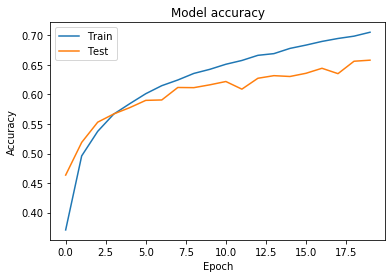

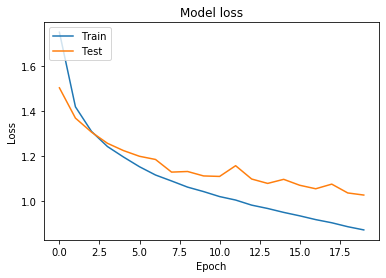

In [122]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Perturbations (FGSM, norme infinie et FGM, norme L2)

In [0]:
#create the perturbations
#the perturbations are on the test set
image = tf.cast(x_test, tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_test, prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations_inf = tf.sign(gradient).numpy()*epsilon_inf 

perturbations_l2 = np.zeros((len(x_test),32,32,3))
for i in range(len(x_test)):
  perturbations_l2[i]=(epsilon_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

x_test_fgsm = x_test + perturbations_inf
x_test_fgm = x_test + perturbations_l2 

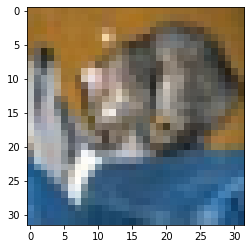

In [133]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


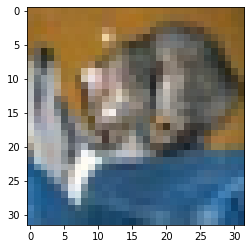

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


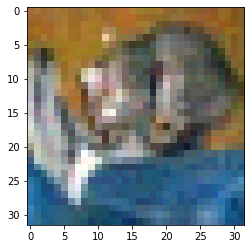

In [134]:
#the modified image(FGM)
plt.imshow(x_test_fgm[0].reshape((32, 32, 3)))
plt.show()

#the modified image(FGSM)
plt.imshow(x_test_fgsm[0].reshape((32, 32, 3)))
plt.show()

In [135]:
#results for the original image
print(adversarial.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [136]:
#results for the modified image (FGM) norme L2
print(adversarial.evaluate(x_test_fgm, y_test))

#results for the modified image (FGSM) norme Inf
print(adversarial.evaluate(x_test_fgsm,y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Perturbations (PGD avec norme infinie et norme L2)

In [0]:
#create the perturbations

#Norme infinie 

x_test_pgd_inf = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)
    
for step in range(step_pgd):
  image = tf.cast(x_test_pgd_inf, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
  
  perturbations_inf = tf.sign(gradient).numpy()*eta_inf
  x_test_pgd_inf = x_test_pgd_inf + perturbations_inf
  x_test_pgd_inf = np.maximum(np.minimum(x_test_pgd_inf, x_test + epsilon), x_test - epsilon)

In [0]:
#Norme L2

x_test_pgd_l2 = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)

for step in range(step_pgd):
  image = tf.cast(x_test_pgd_l2, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
  
  gradient = tape.gradient(loss,image)

  perturbations_l2 = np.zeros((len(x_test),32,32,3))
  for i in range(len(x_test_pgd_l2)):
    perturbations_l2[i]=(eta_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

  x_test_pgd_l2 = x_test_pgd_l2 + perturbations_l2
  x_test_pgd_l2 = np.maximum(np.minimum(x_test_pgd_l2,x_test + epsilon),x_test - epsilon)

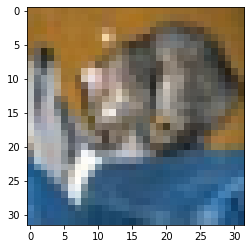

In [148]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


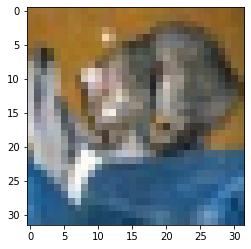

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


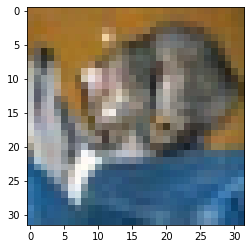

In [149]:
#the modified image (PGD)

#Norme Inf
plt.imshow(x_test_pgd_inf[0].reshape((32, 32, 3)))
plt.show()

#Norme L2
plt.imshow(x_test_pgd_l2[0].reshape((32, 32, 3)))
plt.show()

In [150]:
#results for the modified image

#Norme Inf 
print(adversarial.evaluate(x_test_pgd_inf, y_test))

#Norme L2 
print(adversarial.evaluate(x_test_pgd_l2, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================